In [1]:
import numpy as np
import tqdm 
import osyris
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import sys
import os

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [3]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1236.02it/s]


Converged mean angular momentum vector after 0 iteration(s)


Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9126.48it/s] 


Disk size: 17.9 au


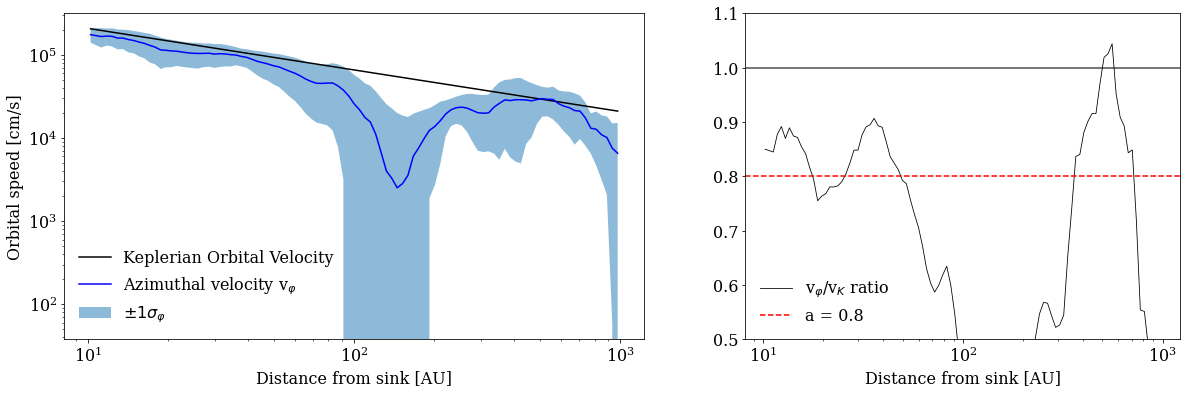

In [4]:
data.calc_disksize()

In [5]:
from matplotlib.cm import ScalarMappable
def phi_average(self, radius = 50, height = 20, NR = 80, Nh_half = 30, origo_close = 1, phi_extent = None, quiver_dens = 0.6, log_vmin = -20, log_vmax = -12, ivs = None):
    radius /= self.au_length; height /= self.au_length
    selection_radius = np.sqrt(radius**2 + height**2) * 1.2 

    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities
    extracted_names = ['R', 'z', 'vR', 'vz', 'mass', 'vol']
    print('Extracting patch data')
    for p in tqdm.tqdm(sorted_patches):
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        try: 
            p.trans_xyz
        except:
            self.calc_trans_xyz()
        to_extract = (p.cyl_R < radius) & (abs(p.cyl_z) < height)
        p.vz = np.sum(p.vrel * self.L[:, None, None, None], axis = 0)
        p.vr = np.sum(p.vrel * p.e_r, axis = 0)
        
        if phi_extent != None: 
            new_x = np.dot(self.rotation_matrix, np.array([1,0,0])); new_y = np.dot(self.rotation_matrix, np.array([0,1,0]))
            proj_r = np.sum(p.cyl_r * new_x[:, None, None, None], axis = 0)
            proj_φ = np.sum(p.cyl_r * new_y[:, None, None, None], axis = 0)
            p.φ = np.arctan2(proj_φ, proj_r) + np.pi
            to_extract *= (p.φ > phi_extent[0]) & (p.φ < phi_extent[1]) 
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 

        vel_r = p.vr[to_extract].T
        vel_z = p.vz[to_extract].T
        z_coor = p.cyl_z[to_extract].T 
        R_coor = p.cyl_R[to_extract].T
        mass_val = p.m[to_extract].T
        if ivs != None: value = p.var(ivs)[to_extract].T
        
        extracted_values[0].extend(R_coor.tolist())
        extracted_values[1].extend(z_coor.tolist())
        extracted_values[2].extend(vel_r.tolist())
        extracted_values[3].extend(vel_z.tolist())
        extracted_values[4].extend(mass_val.tolist())
        extracted_values[5].extend(p.ds[0]**3 * np.ones(len(mass_val)))
        if ivs != None: extracted_values[6].extend(value)

    for key in extracted_values:
        extracted_values[key] = np.array(extracted_values[key])

    print('Making grid and interpolation')
    # Grid for the values e.g. density
    R_grid= np.logspace(np.log10(origo_close), np.log10(radius * self.au_length), NR) / self.au_length; R_grid = np.insert(R_grid, 0, 0) 
    z_grid = np.logspace(np.log10(origo_close), np.log10(height * self.au_length), Nh_half) / self.au_length; z_grid = np.insert(z_grid, 0, 0)
    
    z_grid = np.concatenate((-np.logspace(np.log10(origo_close), np.log10(height * self.au_length), Nh_half)[::-1] / self.au_length , z_grid))
    hist_mass, binedges_R, binedges_z = np.histogram2d(extracted_values[0], extracted_values[1], bins = (R_grid, z_grid), weights=extracted_values[4])
    if ivs != None:
        hist_val, _, _ = np.histogram2d(extracted_values[0], extracted_values[1], bins = (R_grid, z_grid), weights=extracted_values[6] * extracted_values[4])
        hist_val /= hist_mass
    hist_vol, _, _ = np.histogram2d(extracted_values[0], extracted_values[1], bins = (R_grid, z_grid), weights=extracted_values[5] * self.sn.scaling.l**3)
    hist_ρ = (hist_mass* self.sn.scaling.m) / hist_vol
    R_bins = R_grid[:-1] + 0.5 * np.diff(binedges_R)
    z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)

    # Here starts the grid for the velocity field
    quiver_shift = 1
    quivergrid_vr = np.linspace(origo_close/2, R_grid.max() * self.au_length - quiver_shift, int(NR * quiver_dens)) / self.au_length
    quivergrid_vz = np.linspace(origo_close/2, z_grid.max() * self.au_length - quiver_shift, int(Nh_half * quiver_dens)) / self.au_length
    quivergrid_vz = np.concatenate((-np.linspace(origo_close/2, z_grid.max() * self.au_length - quiver_shift, int(Nh_half * quiver_dens))[::-1] / self.au_length, quivergrid_vz))

    counts, qbinedgesR, qbinedgesz = np.histogram2d(extracted_values[0], extracted_values[1], bins = (quivergrid_vr, quivergrid_vz))
    hist_vr, _, _ = np.histogram2d(extracted_values[0], extracted_values[1], bins = (quivergrid_vr, quivergrid_vz), weights=extracted_values[2] * self.cms_velocity)
    hist_vz, _, _ = np.histogram2d(extracted_values[0], extracted_values[1], bins = (quivergrid_vr, quivergrid_vz), weights=extracted_values[3] * self.cms_velocity)

    vR_bins = quivergrid_vr[:-1] + 0.5 * np.diff(qbinedgesR)
    vz_bins = quivergrid_vz[:-1] + 0.5 * np.diff(qbinedgesz)

    arrow_length = np.sqrt((hist_vr/counts)**2 + (hist_vz/counts)**2)
    arrow_length[np.isnan(arrow_length)] = 1e-20

    rr_ρ, zz_ρ = np.meshgrid(R_bins, z_bins, indexing='ij')
    rr_v, zz_v = np.meshgrid(vR_bins, vz_bins, indexing='ij')
    
    mask = np.isnan(hist_ρ.flatten())
    masked_hist_ρ = np.ma.masked_array(hist_ρ.flatten(), mask=mask)
    if ivs != None: 
        masked_hist_val = np.ma.masked_array(hist_val.flatten(), mask=mask)
        interpolation_val = interpolate.griddata(np.hstack((rr_ρ.flatten()[:,None][~mask], zz_ρ.flatten()[:,None][~mask])), masked_hist_val[~mask], xi = (rr_ρ, zz_ρ), method = 'linear')
    interpolation = interpolate.griddata(np.hstack((rr_ρ.flatten()[:,None][~mask], zz_ρ.flatten()[:,None][~mask])), masked_hist_ρ[~mask], xi = (rr_ρ, zz_ρ), method = 'linear')

    # Here begins the plotting
    fig, axs = plt.subplots(figsize = (12,8))
    cs = axs.contourf(R_bins * self.au_length, z_bins*self.au_length, np.log10(interpolation.T), vmin = log_vmin, vmax = log_vmax, origin = 'lower', levels = 200, cmap = 'gist_heat')
    cbar = fig.colorbar(ScalarMappable(norm=cs.norm, cmap=cs.cmap), ticks = range(log_vmin, log_vmax + 1, 1), ax = axs, fraction = 0.1, pad = 0.06, location = 'top');

    quiver = axs.quiver(rr_v * self.au_length, zz_v*self.au_length, (hist_vr/counts)/arrow_length , (hist_vz/counts)/arrow_length, np.log10(arrow_length), 
                        cmap=mpl.cm.Greys, headwidth = 2.5, headaxislength = 2.3, headlength = 2.3, pivot = 'mid', scale = 100 / (0.6 /quiver_dens));
    cbar_vel = fig.colorbar(quiver, pad = 0.005)
    cbar_vel.set_label('$\log_{10}(V)$ [cm/s]')
    cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -60, x = -0.08, rotation = 0, fontsize = 18)
    axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Distance from star  [AU]');
    if phi_extent != None:
        axs.set_title(f'Averaged over φ: [{phi_extent[0]:1.2f},{phi_extent[1]:1.2f}] rad')
    axs.axhline(0, c='black', alpha = 0.4)
    fig.tight_layout()
    if ivs != None: return R_bins, z_bins, interpolation_val
pipeline.phiaverage = phi_average

Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 1220.10it/s]
/tmp/ipykernel_1241632/2433345013.py:65: RuntimeWarning: invalid value encountered in true_divide
  hist_val /= hist_mass
/tmp/ipykernel_1241632/2433345013.py:67: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = (hist_mass* self.sn.scaling.m) / hist_vol


Making grid and interpolation


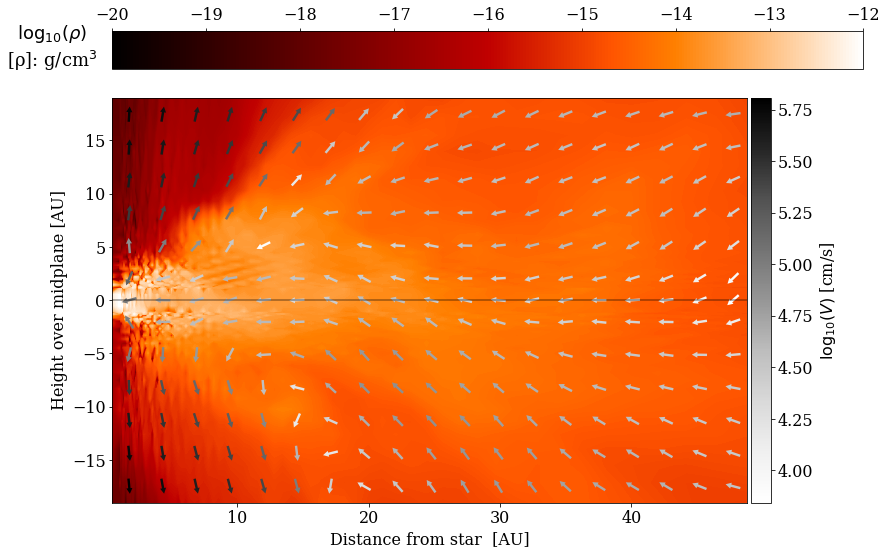

In [8]:
R, z, val = data.phiaverage(ivs = '(px**2 + py**2 + pz**2)**0.5', quiver_dens=0.25)
#plt.savefig('graphics/phiaverage', dpi = 1000, facecolor = 'w')

Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 1170.64it/s]
/tmp/ipykernel_1935459/2501705680.py:65: RuntimeWarning: invalid value encountered in true_divide
  hist_val /= hist_mass
/tmp/ipykernel_1935459/2501705680.py:67: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = (hist_mass* self.sn.scaling.m) / hist_vol


Making grid and interpolation


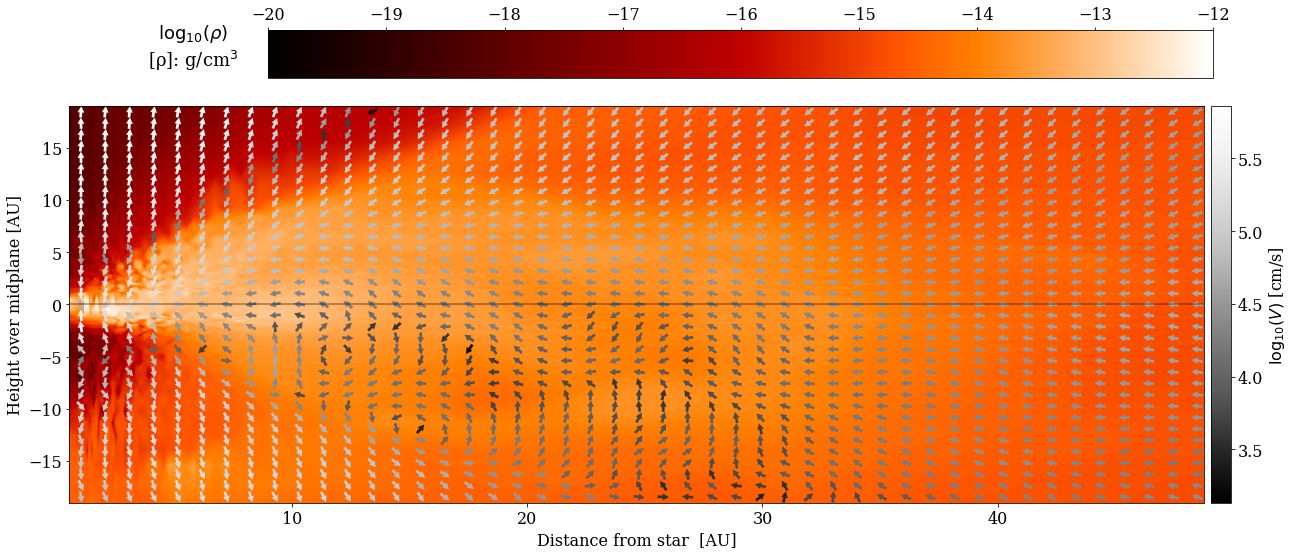

In [29]:
R, z, val = data.phiaverage(ivs = '(px**2 + py**2 + pz**2)**0.5', quiver_dens=0.6)
plt.savefig('graphics/phiaverage2', dpi = 1000, facecolor = 'w')

[Text(0.5, 1.0, 'Pressure')]

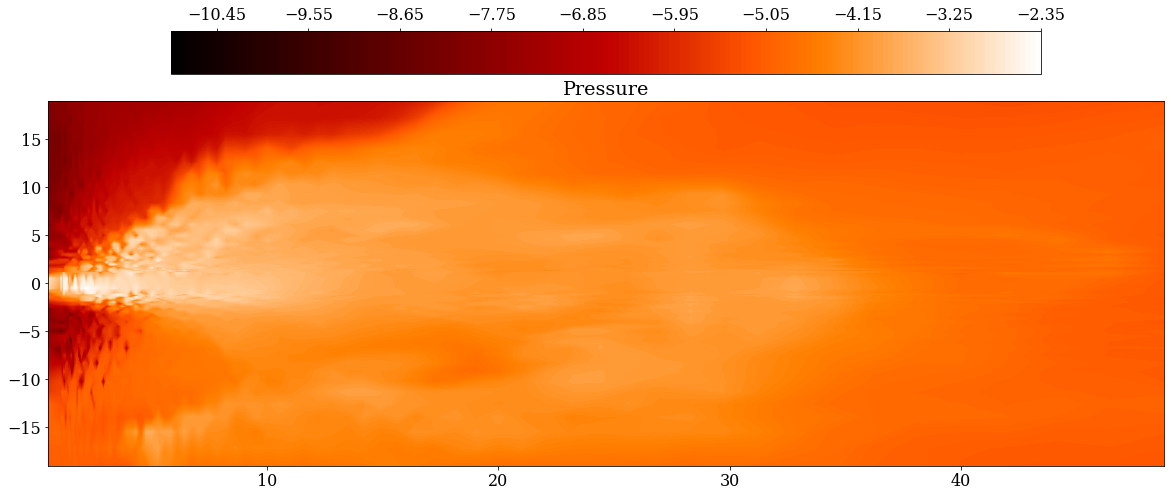

In [76]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.contourf(R * data.au_length, z*data.au_length, np.log10(val.T * data.sn.scaling.e / data.sn.scaling.l**3), origin = 'lower', levels = 200, cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.1, pad = 0.06, location = 'top');
axs.set(title='Magnetic field')

Extracting patch data


  0%|          | 0/434 [00:00<?, ?it/s]

100%|██████████| 434/434 [00:00<00:00, 2643.65it/s]

Making grid and interpolation


/tmp/ipykernel_937948/4291336928.py:67: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = (hist_mass* self.sn.scaling.m) / hist_vol



Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 2744.16it/s]

Making grid and interpolation

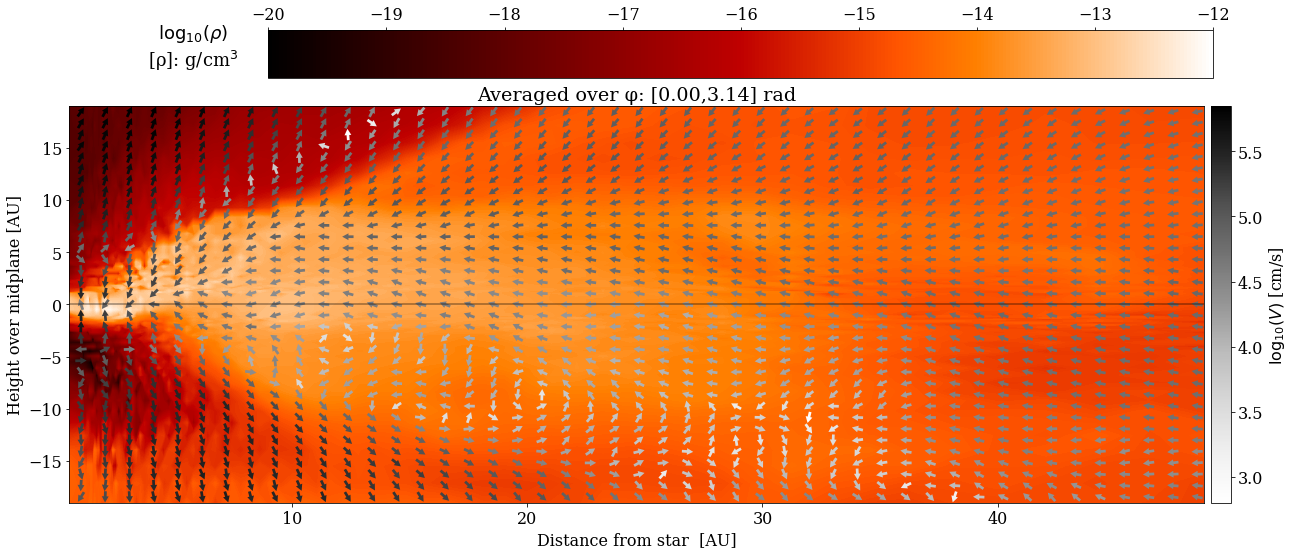

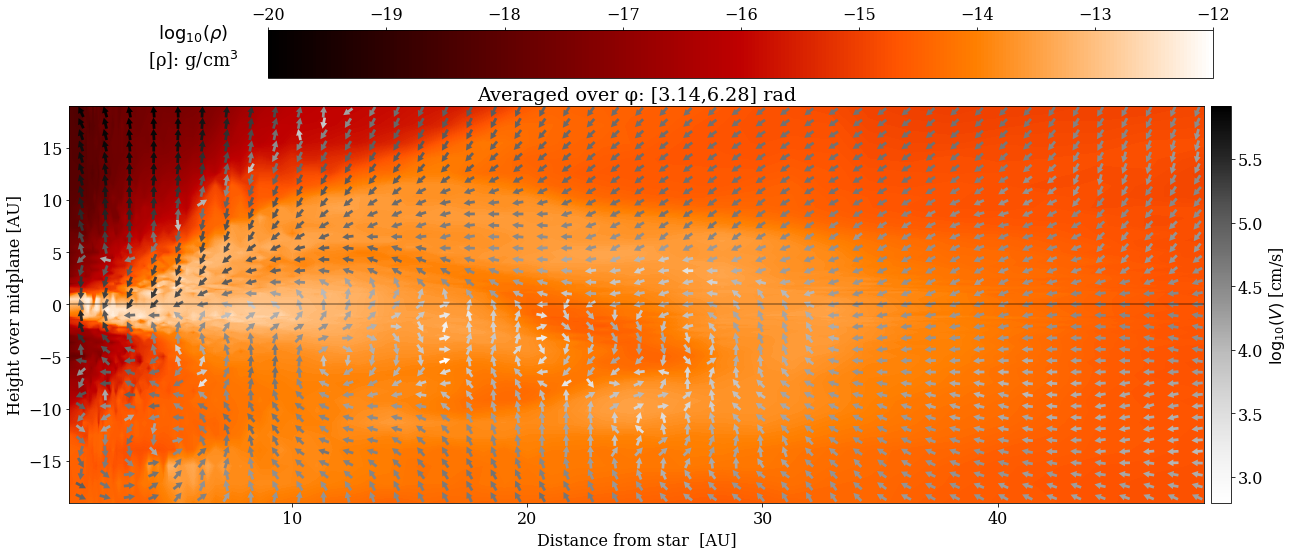

In [73]:
data.phiaverage(phi_extent=[0, np.pi])
data.phiaverage(phi_extent=[np.pi, 2*np.pi])

Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 3186.56it/s]

Making grid and interpolation



/tmp/ipykernel_937948/1698757906.py:62: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass / hist_vol


Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 3508.35it/s]

Making grid and interpolation


Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 3217.49it/s]

Making grid and interpolation


Extracting patch data


100%|██████████| 434/434 [00:00<00:00, 3269.69it/s]

Making grid and interpolation


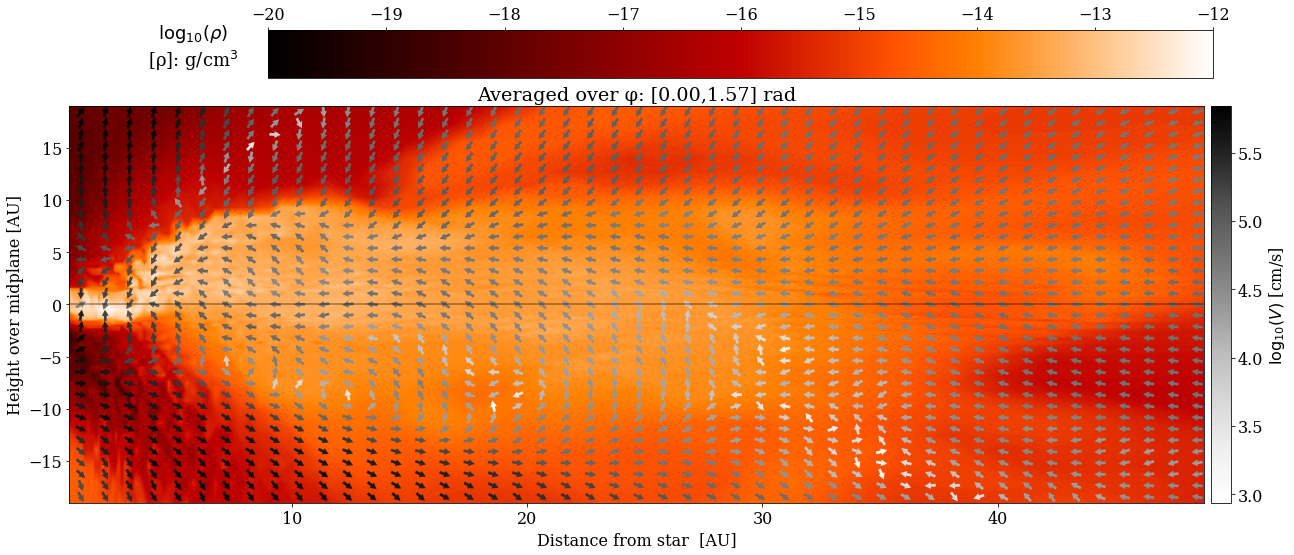

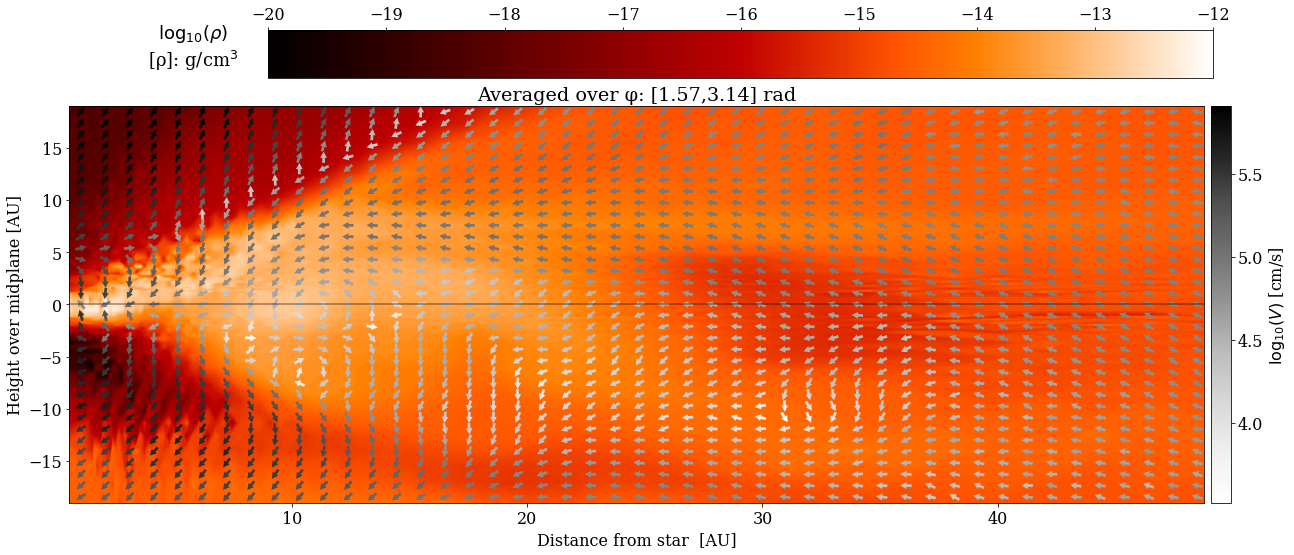

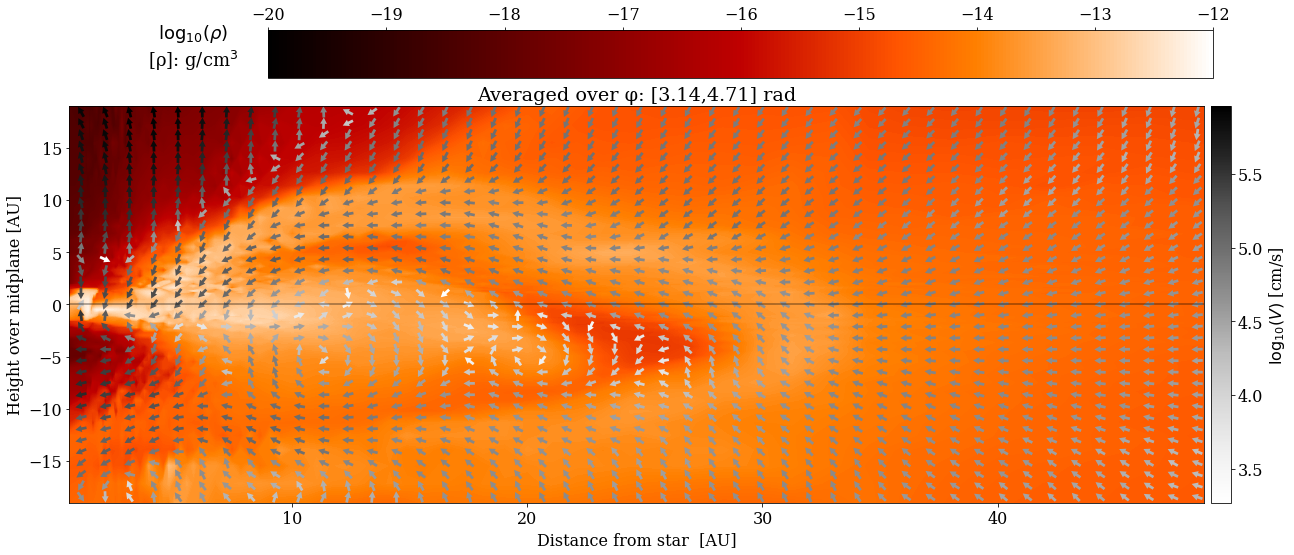

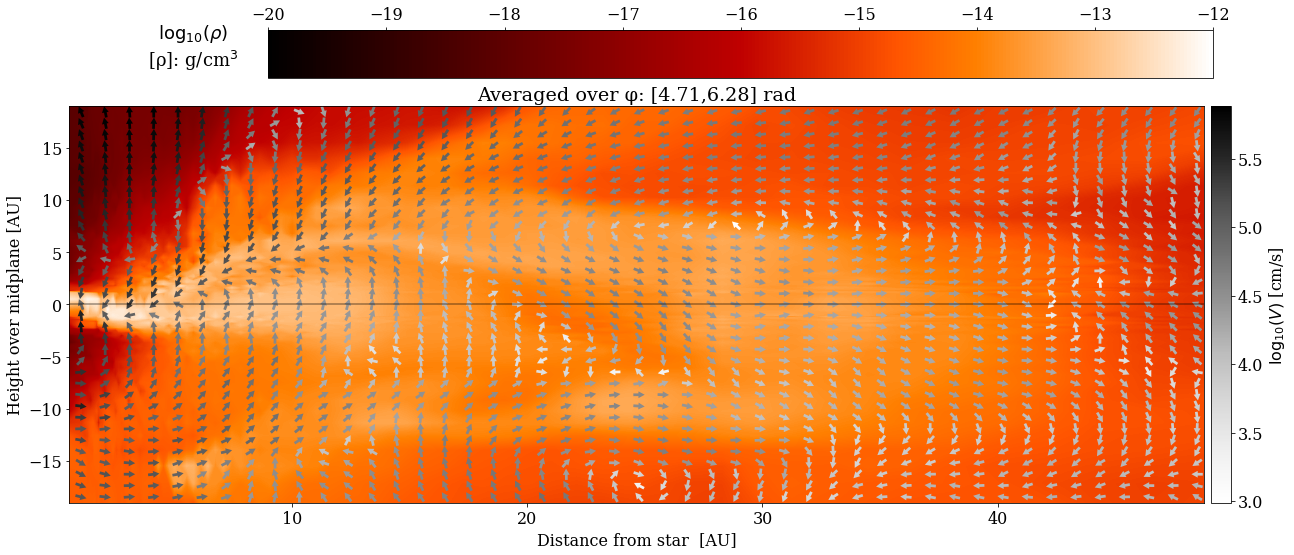

In [52]:
data.phiaverage(phi_extent=[0, 0.5*np.pi])
data.phiaverage(phi_extent=[0.5*np.pi, np.pi])
data.phiaverage(phi_extent=[np.pi, 3*np.pi/2])
data.phiaverage(phi_extent=[ 3*np.pi/2, 2*np.pi])